<a href="https://colab.research.google.com/github/rinrin528/AIFFEL-1st-Hackathon/blob/main/EDA%2B%EC%A0%84%EC%B2%98%EB%A6%AC%2B%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 해커톤1. 레스토랑 방문자 수 예측하기

## 데이터셋: [Recruit Restaurant Visitor Forecasting | Kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/overview)



---



## 🔍문제 이해하기
-	a time-series forecasting problem
-	2개 사이트에서 얻은 데이터셋이다.
 - hpg (Hot Pepper Gourmet): 레스토랑을 찾거나 예약할 수 있는 사이트
 - air (AirReGI/Restaurant Borad): 예약 관리, 사전계산 가능한 사이트
-	훈련데이터는 **2016년부터 2017년4월**까지, 테스트데이터는 **2016년 4월마지막주부터 5월**동안의 데이터이다. <br> (테스트데이터는 의도적으로 휴가철 데이터를 설정하였다.)
-	테스트셋에서 레스토랑이 닫거나 방문자가 없는 날은 scoring되지 않는다. 훈련데이터셋에서는 레스토랑이 닫은 날은 생략했다.



---




## 📊데이터셋 이해하기 (8개)

**1.	air_reserve:** air사이트에서 이뤄진 예약들<br>
- 칼럼) air_store_id, visit_datetime(방문시각), reserve_datetime(예약시각), reserve_visitors(예약방문자수)

**2.	hpg_reserve:** hpg사이트에서 이뤄진 예약들<br>
- 칼럼) hpg_store_id, visit_datetime, reserve_datetime, reserve_visitors<br>

**3.	air_store_info:** air사이트의 레스토랑 정보<br>
- 칼럼) air_store_id, air_genre_name(레스토랑종류), air_area_name(지역구이름), latitude(위도), longitude(경도)<br>

**4.	hpg_store_info:** hpg사이트의 레스토랑 정보<br>
- 칼럼) hpg_store_id, hpg_genre_name, hpg_area_name, latitude, longitude<br>

**5.	store_id_relation**<br>
- 칼럼) hpg_store_id, air_store_id<br>

**6.	air_visit_data**: air레스토랑들의 방문이력을 보여준다.
- **training 데이터**
- 칼럼) air_store_id, visit_date, **visitors(방문자수)**

**7.	sample_submission:** 우리가 예측해야하는 정답과 정답의 포맷을 보여준다.
- **test 데이터**
- 칼럼) id, **visitors(방문자수)**

**8.	date_info**: 데이터셋의 날짜 관련 기본정보를 제공한다.<br>
- 칼럼) calendar_date(날짜), day_of_week(요일), holiday_fig(일본의 휴일)

In [73]:
# 데이터 분석 및 모델 학습 라이브러리
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime
import glob, re
import time, datetime
from datetime import timedelta

# 시각화 라이브러리
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

print('[----Data structure----]')
print('Training data:\t\t',data['tra'].shape, '\tunique store id: ',len(data['tra']['air_store_id'].unique()))
print('Id data:\t\t',data['id'].shape)
print('Air store data:\t\t',data['as'].shape,'\tunique store id: ',data['as']['air_store_id'].unique().shape)
print('Hpg store data:\t\t',data['hs'].shape,'\tunique store id: ',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data:\t',data['ar'].shape,'\tunique store id: ',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data:\t',data['hr'].shape,'\tunique store id: ',data['hr']['hpg_store_id'].unique().shape)

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])        # hpg reserve data
data['hs'] = pd.merge(data['hs'], data['id'], how='inner', on=['hpg_store_id'])        # hpg store data

for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])  
    data[df]['hour']=data[df]['visit_datetime'].dt.hour
    data[df]['dow'] = data[df]['visit_datetime'].dt.dayofweek              # 요일 컬럼 생성  (정수 0~6)
    data[df]['dow_name'] = data[df]['visit_datetime'].dt.day_name()        # 요일명 컬럼 생성 (Monday ~ Sunday)
    data[df]['visit_day'] = data[df]['visit_datetime'].dt.day                    # 일 칼럼 생성
    data[df]['visit_hour'] = data[df]['visit_datetime'].dt.hour            # 시간 칼럼 생성
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_hour'] = data[df]['reserve_datetime'].dt.hour        # 시간 칼럼 생성
    data[df]['reserve_day'] = data[df]['reserve_datetime'].dt.day              # 일 칼럼 생성
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date

    data[df+'_hour'] = data[df]

    # (방문날짜 - 예약날짜)를 'reserve_date_diff'칼럼에 저장하고
    # air store id와 방문날짜를 기준으로 그룹화한다.
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])    # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek              # 요일 컬럼 생성  (정수 0~6)
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()        # 요일명 컬럼 생성 (Monday ~ Sunday)
data['tra']['year'] = data['tra']['visit_date'].dt.year                  # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month                # month 컬럼 생성

data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)    # 연도-월 형태로 저장

[----Data structure----]
Training data:		 (252108, 3) 	unique store id:  829
Id data:		 (150, 2)
Air store data:		 (829, 5) 	unique store id:  (829,)
Hpg store data:		 (4690, 5) 	unique store id:  (4690,)
Air reserve data:	 (92378, 4) 	unique store id:  (314,)
Hpg reserve data:	 (2000320, 4) 	unique store id:  (13325,)


# ✨시각화

## data1. air_visit_data

### 1) 일일 방문자 수
일별 편차는 꾸준히 존재하며, 2016년 7월 ~ 2016년 12월에 일일 방문자 수가 전체적으로 확연히 크다.<br>
반면 2016년 1월 ~ 2016년 6월 사이의 방문자 수가 전체적으로 작다.

Text(0, 0.5, 'Sum of Visitors')

Text(0.5, 1.0, 'Visitors per Day')

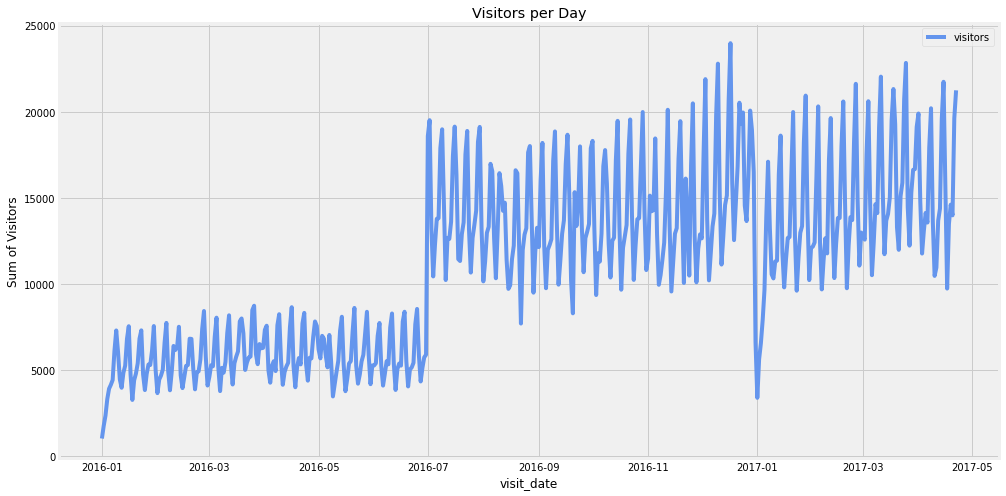

In [ ]:
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['tra'].groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})   # 방문날짜를 기준으로 묶어서 방문자 수를 더한값
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitors per Day")

### 2) 요일별 평균 방문자 수

In [ ]:
df = data['tra'].groupby('dow_name').mean().drop(['year', 'month', 'dow'], axis=1)
order_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df.reindex(index=order_dow)

,visitors
dow_name,
Monday,17.177009
Tuesday,17.672137
Wednesday,19.230121
Thursday,18.922702
Friday,23.072737
Saturday,26.313688
Sunday,23.873362


토요일에 방문하는 손님이 제일 많다.<br>
금토일이 나머지 요일보다 비교적 방문자가 많다.

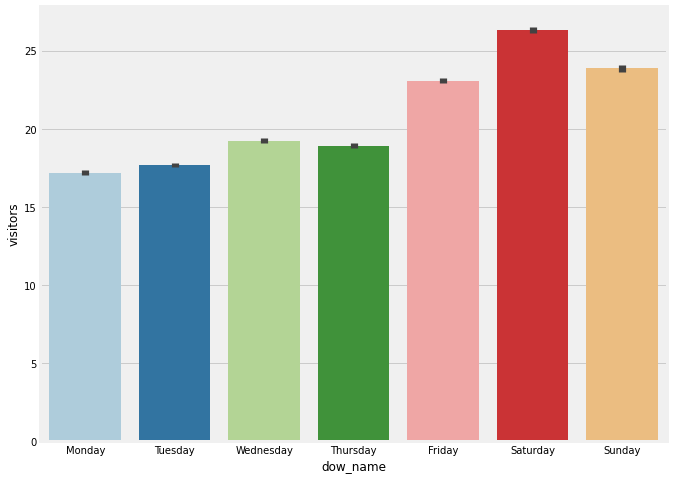

In [ ]:
fig = plt.figure(figsize=(10,8))

sns.barplot(x='dow_name', y='visitors', data=data['tra'], order=order_dow, palette="Paired")

### 3) 방문자 수 빈도 
R의 ggplot을 라이브러리를 통해 파이썬에서 사용할 수 있다.


[[Python] Python에서 R ggplot2 함수로 그래프 그리기 (by PlotNine library)](https://rfriend.tistory.com/420)

In [ ]:
print(data['tra']['visitors'].max())
print(data['tra']['visitors'].mean())

877
20.973761245180636


방문자 수의 평균은 20이지만 최댓값인 877이라는 이상치가 있어서 구간

<Figure size 432x288 with 0 Axes>

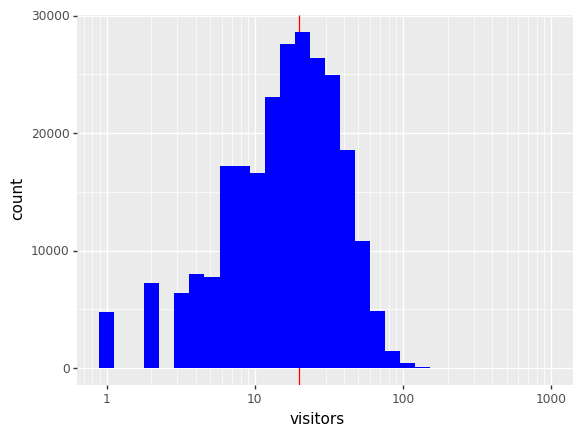

<ggplot: (8776460750017)>

In [ ]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes('visitors')) +\
  geom_vline(xintercept = 20, color = 'red') +\
  geom_histogram(fill = 'blue', bins = 30) +\
  scale_x_log10()

### 4) 요일-월 방문자수 히트맵
월간 큰 차이는 없지만 그 중 일요일에 가장 방문자가 많다.<br>
요일별 차이는 월별 차이보다 훨씬 크다.<br>
금, 토, 일요일에 해당하는 부분이 나머지와 명확히 구분된다.

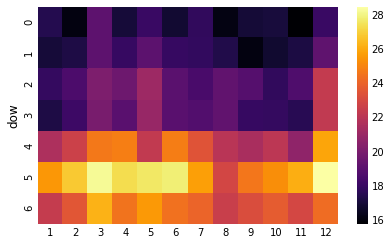

In [ ]:
df = pd.pivot_table(data['tra'], index=['dow'], columns='month',values='visitors',aggfunc=[np.mean],fill_value=0)
df.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

sns.heatmap(df, cmap='inferno')

## data2. air_reserve

### 5) 일일 예약방문자 수 (air)

Text(0.5, 1.0, "'air' visit date")

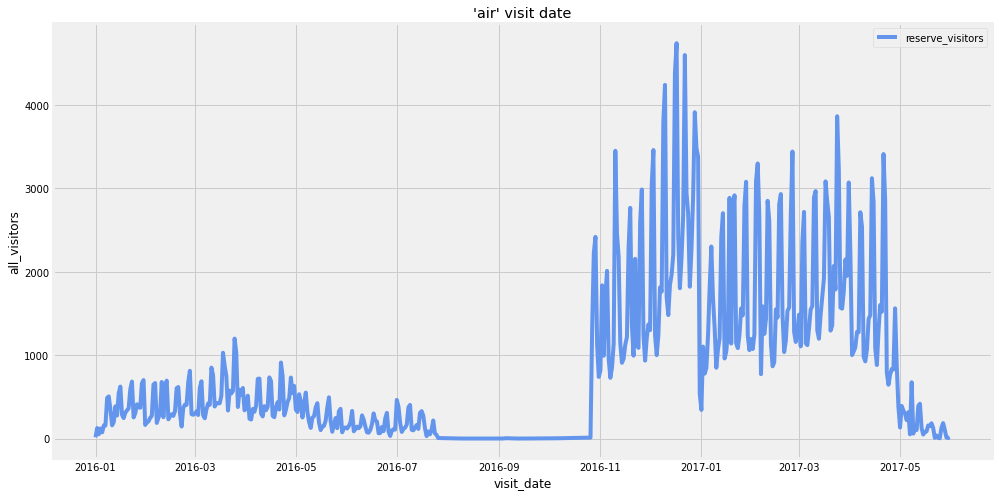

In [ ]:
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['ar'].groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})   # 예약날짜를 기준으로 묶어서 예약방문자 수를 더한값
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line', ax=ax)

plt.ylabel("all_visitors")
plt.title("'air' visit date")

2016년의 예약은 많이 저조해보이고, 심지어 긴시간 없는 구간도 보인다. 16년 연말 동안만 예약이 늘었다.<br>
2017년의 고객수는 2016년에 비해 훨씬 많다.

## data3. hpg_reserve

### 6) 일일 예약방문자 수 (hpg)
hpg를 통한 예약 방문자는 2016년 12월에 제일 많다.<br>
연말이라 사람들이 미리 예약을 많이 한 것으로 보인다.

Text(0, 0.5, 'Sum of Visitors')

Text(0.5, 1.0, 'Visitors per Day')

<Figure size 3600x3600 with 0 Axes>

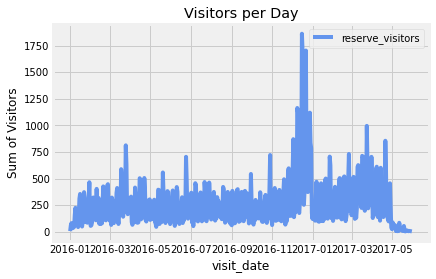

In [ ]:
fig = plt.figure(figsize=(50, 50))

plt1 = data['hr'].groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})   # 방문날짜를 기준으로 묶어서 방문자 수를 더한값
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line')

plt.ylabel("Sum of Visitors")
plt.title("Visitors per Day")

plt.show()

## data1 & data2 & data3

### 7) 일일 방문자 수와 예약방문자 수 비교

Text(0, 0.5, 'Sum of Visitors')

Text(0.5, 1.0, 'Visitors and Reserve Visitors')

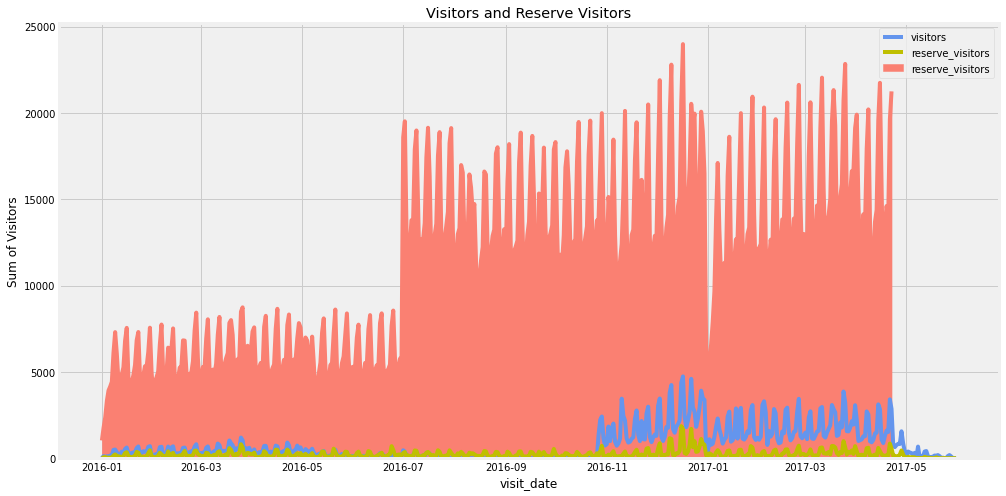

In [ ]:
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['tra'].groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt2 = data['ar'].groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})
plt3 = data['hr'].groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})
plt1=plt1.set_index('visit_date')
plt2=plt2.set_index('visit_date')
plt3=plt3.set_index('visit_date')
plt1.plot(color='salmon', kind='area', ax=ax)
plt2.plot(color='cornflowerblue', kind='line', ax=ax)
plt3.plot(color='y', kind='line', ax=ax)
plt.ylabel("Sum of Visitors")
plt.title("Visitors and Reserve Visitors")

### 8) air와 hpg 분포 비교

1. 일일 예약방문자 비교

2. 요일별 예약방문자 비교

3. 시간대별 예약자, 방문자 분포

<BarContainer object of 40 artists>

<BarContainer object of 40 artists>

<BarContainer object of 7 artists>

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Air Reservation in Number of Days')

Text(0.5, 1.0, 'Hpg Reservation in Number of Days')

Text(0.5, 1.0, 'Air reserve visitors by dow')

Text(0.5, 1.0, 'Hpg reserve visitors by dow')

Text(0.5, 1.0, 'Air Reserve Hour x Visit hour')

Text(0.5, 1.0, 'Hpg Reserve Hour x Visit hour')

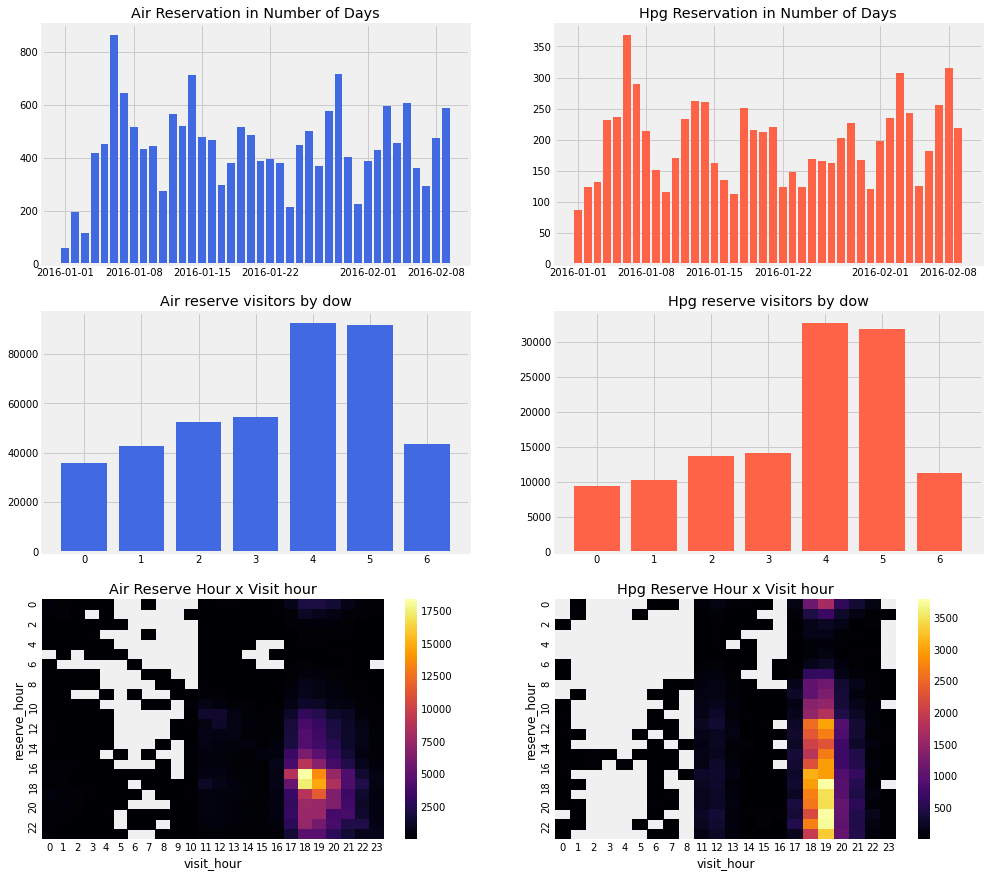

In [62]:
data['ar_hour']['reserve_datetime'] = pd.to_datetime(data['ar_hour']['reserve_datetime'])
data['ar_hour']['visit_datetime'] = pd.to_datetime(data['ar_hour']['visit_datetime'])
data['ar_hour']['dow_reserve'] = data['ar_hour']['reserve_datetime'].dt.weekday
data['ar_hour']['dow_visit'] = data['ar_hour']['visit_datetime'].dt.weekday

data['hr_hour']['reserve_datetime'] = pd.to_datetime(data['hr_hour']['reserve_datetime'])
data['hr_hour']['visit_datetime'] = pd.to_datetime(data['hr_hour']['visit_datetime'])
data['hr_hour']['dow_reserve'] = data['hr_hour']['reserve_datetime'].dt.weekday
data['hr_hour']['dow_visit'] = data['hr_hour']['visit_datetime'].dt.weekday
air_res= data['ar_hour'].groupby(['reserve_datetime'],as_index=False)['reserve_visitors'].sum()[:40]
hpg_res= data['hr_hour'].groupby(['reserve_datetime'],as_index=False)['reserve_visitors'].sum()[:40]
air_res2=data['ar_hour'].groupby(['dow_visit',],as_index=False)['reserve_visitors'].sum()
hpg_res2=data['hr_hour'].groupby(['dow_visit',],as_index=False)['reserve_visitors'].sum()
air_res3=data['ar_hour'].groupby(['reserve_hour','visit_hour'])['reserve_visitors'].sum().unstack()
hpg_res3=data['hr_hour'].groupby(['reserve_hour','visit_hour'])['reserve_visitors'].sum().unstack()

f, ax=plt.subplots(3,2, figsize=(15,15),sharey=False)
ax[0,0].bar(air_res['reserve_datetime'] ,air_res['reserve_visitors'],color='royalblue')
ax[0,1].bar(hpg_res['reserve_datetime'] ,hpg_res['reserve_visitors'],color='tomato')
ax[1,0].bar(air_res2['dow_visit'] ,air_res2['reserve_visitors'],color='royalblue')
ax[1,1].bar(hpg_res2['dow_visit'] ,hpg_res2['reserve_visitors'],color='tomato')
sns.heatmap(air_res3, ax=ax[2,0],cmap='inferno')
sns.heatmap(hpg_res3, ax=ax[2,1],cmap='inferno')
ax[0,0].set_title('Air Reservation Per Day')
ax[0,1].set_title('Hpg Reservation Per Day')
ax[1,0].set_title('Air reserve visitors by dow')
ax[1,1].set_title('Hpg reserve visitors by dow')
ax[2,0].set_title('Air Reserve Hour x Visit hour')
ax[2,1].set_title('Hpg Reserve Hour x Visit hour')

흥미로운점은 air와 hpg가 다른 플랫폼인데도 요일 또는 일일 예약 방문자의 분포가 거의 비슷하다는 점이었다.<br>

## data4 & 5. air_store_info, hpg_store_info
- air에는 총 829개의 가게 정보가 존재한다.
- air는 총 14개의 종류로 식당을 분류하고 있다.
- air에서 포괄하고 있는 지역은 103개이다.
- hpg에는 총 4690개 점포가 입점되어 있다.
- hpg는 총 34개의 종류로 식당을 분류하고 있다.
- hpg에서 포괄하고 있는 지역은 129개이다.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

### 9) 위도, 경도 기준 가게 분포

In [ ]:
import folium
from folium import plugins

location =stores.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Watercolor",# width=1000, height=500,
                        zoom_start = 5)
heatmap=plugins.HeatMap(locationheat).add_to(map1)
map1

### 10) 장르별 가게 위치

In [ ]:
location =stores.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().reset_index()
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)
marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point], popup=location['air_genre_name'][point],
    icon=folium.Icon(color='white', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

### 11) 장르별 가게 분포

- `air`에서는 이자카야, 카페가 타 장르에 비해 월등히 높다.
- `hpg`는 장르 중에서 유의미한 점포 개수를 보유하고 있는 장르 수가 10개 내외이다.
- 또한 전체 가게의 37%가 `Japanese Style`으로 구분되어서 `air_genre_name`에 비해 방문자와의 연관이 약할 가능성이 있다.

In [ ]:
# 분석을 위해 다시 불러오기
data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [ ]:
# 전체 가게 중 Japanese style의 비율
print(len(data['hs'][data['hs']['hpg_genre_name']=='Japanese style'])/len(data['hs']))

0.373134328358209


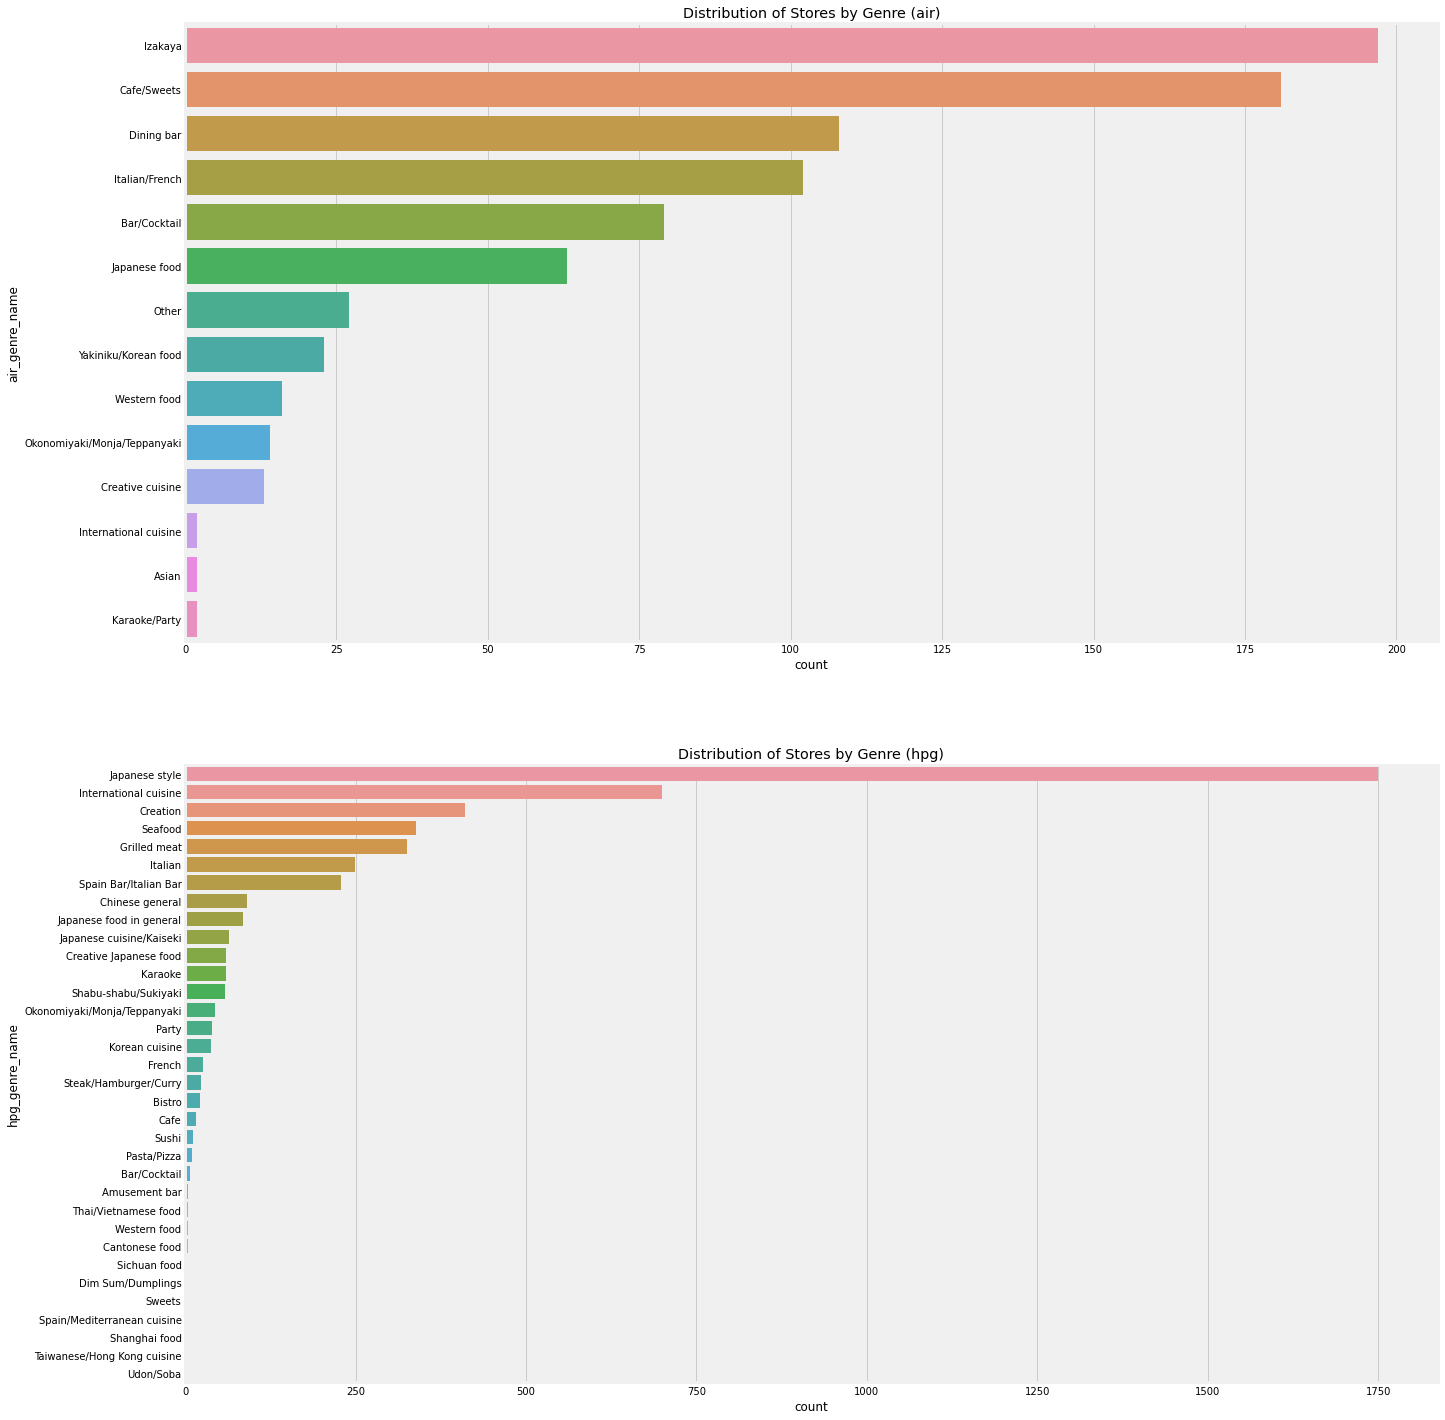

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,25))
sns.countplot(y=data['as']['air_genre_name'],
              order=data['as']['air_genre_name'].value_counts().index,ax=ax1)
sns.countplot(y=data['hs']['hpg_genre_name'],
              order=data['hs']['hpg_genre_name'].value_counts().index,ax=ax2)
ax1.set(title='Distribution of Stores by Genre (air)')
ax2.set(title='Distribution of Stores by Genre (hpg)')
plt.show()

### 12) 지역별 가게 분포
- 지역의 종류가 많으므로 상위 10개 지역에서의 분포와 더 넓은 행정구역 단위의 지역별 분포를 보자

- 단순 `air_area_name`으로만 보면 컬럼 수가 너무 많아서 한눈에 보기 어렵다.

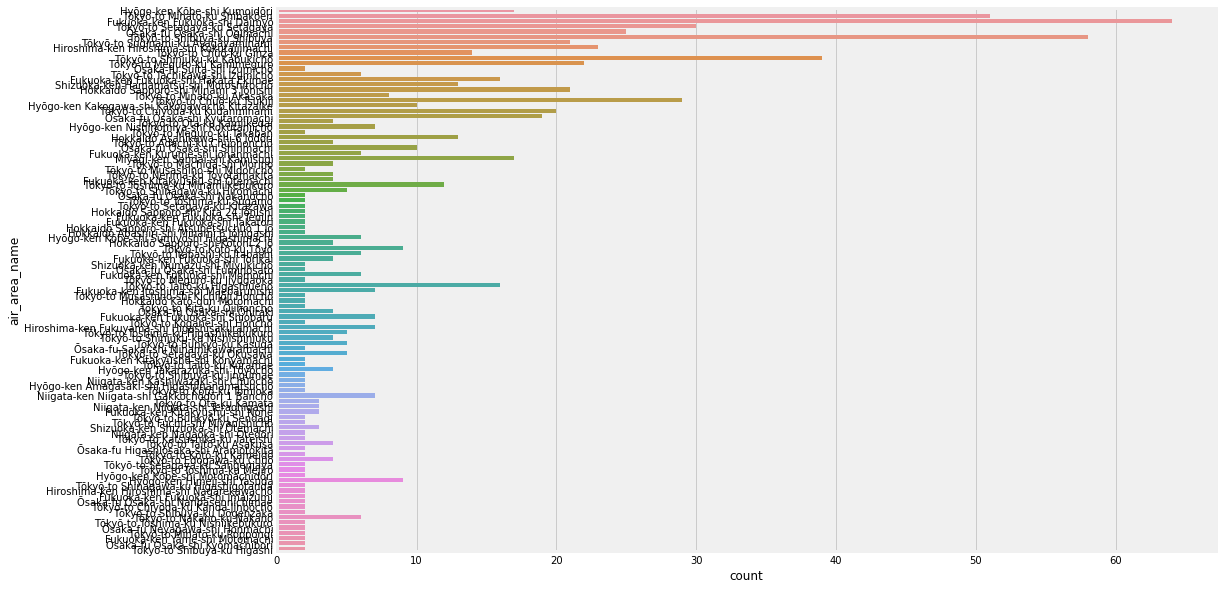

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(y=data['as']['air_area_name'])
plt.show()

- `air_area_name`과 `hpg_area_name`은 도/도/부/현, 시/구, 동으로 구성되어 있다.
- 대단위, 중단위, 소단위 사이는 공백으로 구분되어있다.
- 우선 대단위로 그룹화해서 시각화해보자.

### 13) 도도부현별 가게 분포
- 도도부현 정보를 추출한 칼럼을 추가한다.

In [ ]:
for df, name in [('as','air'),('hs','hpg')]:
  data[df]['dodo'] = data[df][name+'_area_name'].apply(lambda x:x.split(' ')[0])

- air 입점 점포는 도쿄 지역의 가게가 월등히 많은 것을 알 수 있고 그 뒤를 후쿠오카와 오사카가 따르고 있다.
- hpg는 도쿄와 다른 지역의 차이가 air 보다 심하다.
- 그리고 후쿠오카와 오사카의 순위가 바뀌었다.
- 또한 air에서 보지 못했던 None이 발생했다.

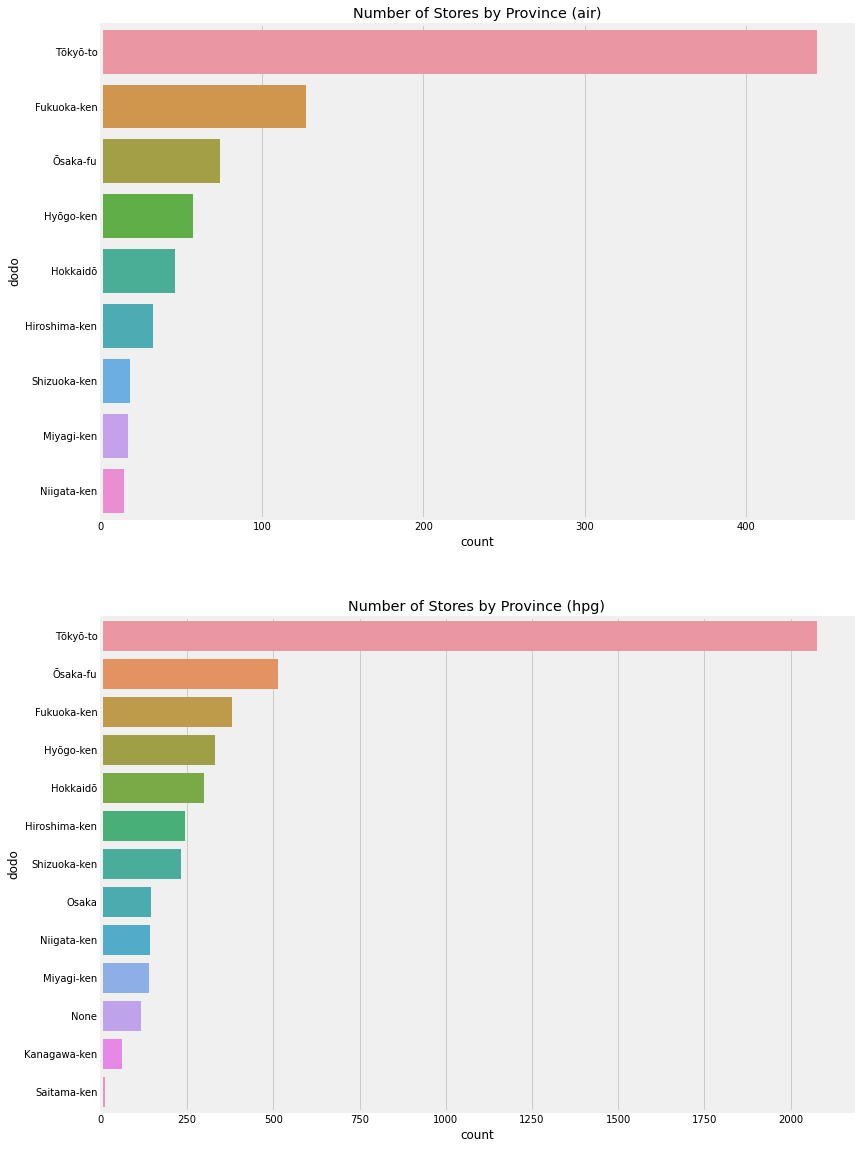

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,20))
sns.countplot(y=data['as']['dodo'],
             order=data['as']['dodo'].value_counts().index, ax=ax1)
sns.countplot(y=data['hs']['dodo'],
             order=data['hs']['dodo'].value_counts().index, ax=ax2)
ax1.set(title='Number of Stores by Province (air)')
ax2.set(title='Number of Stores by Province (hpg)')
plt.show()

- 실제 `hpg_area_name`, `latitude`, `longitude`가 None인 채 `store_id`만 있는 데이터가 117개 있었다.

In [ ]:
data['hs'][data['hs']['dodo']=='None'].head(1)
len(data['hs'][data['hs']['dodo']=='None'])

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,dodo,sigu
651,hpg_5fea90674a2185a0,Japanese style,None None None,35.703381,139.660343,None,None None


117

### 14) 시구별 가게 분포
- 도도부현 - 시구의 정보까지 뽑아보자.

In [ ]:
for df, name in [('as','air'),('hs','hpg')]:
  data[df]['sigu']=data[df][name+'_area_name'].apply(lambda x:' '.join(x.split(' ')[:2]))

In [ ]:
data['as'].nunique()

air_store_id      829
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

- 시/구 단위로 넘어오면서 컬럼 개수가 55개로 증가했으므로 상위 25개만 시각화하기로 했다.
- air에서 시/구 단위로 가장 많은 점포수를 보유한 곳은 후쿠오카시였다. 그 뒤를 오사카시와 시부야구가 뒤를 이었다.
- hpg 가맹 점포는 상대적으로 오사카와 도쿄에 더 집중되어 있다. 
- air에 비해 후쿠오카시 소재 가게의 비율이 낮은 편이다. 지역 정보가 없는 정보도 다수 존재한다.

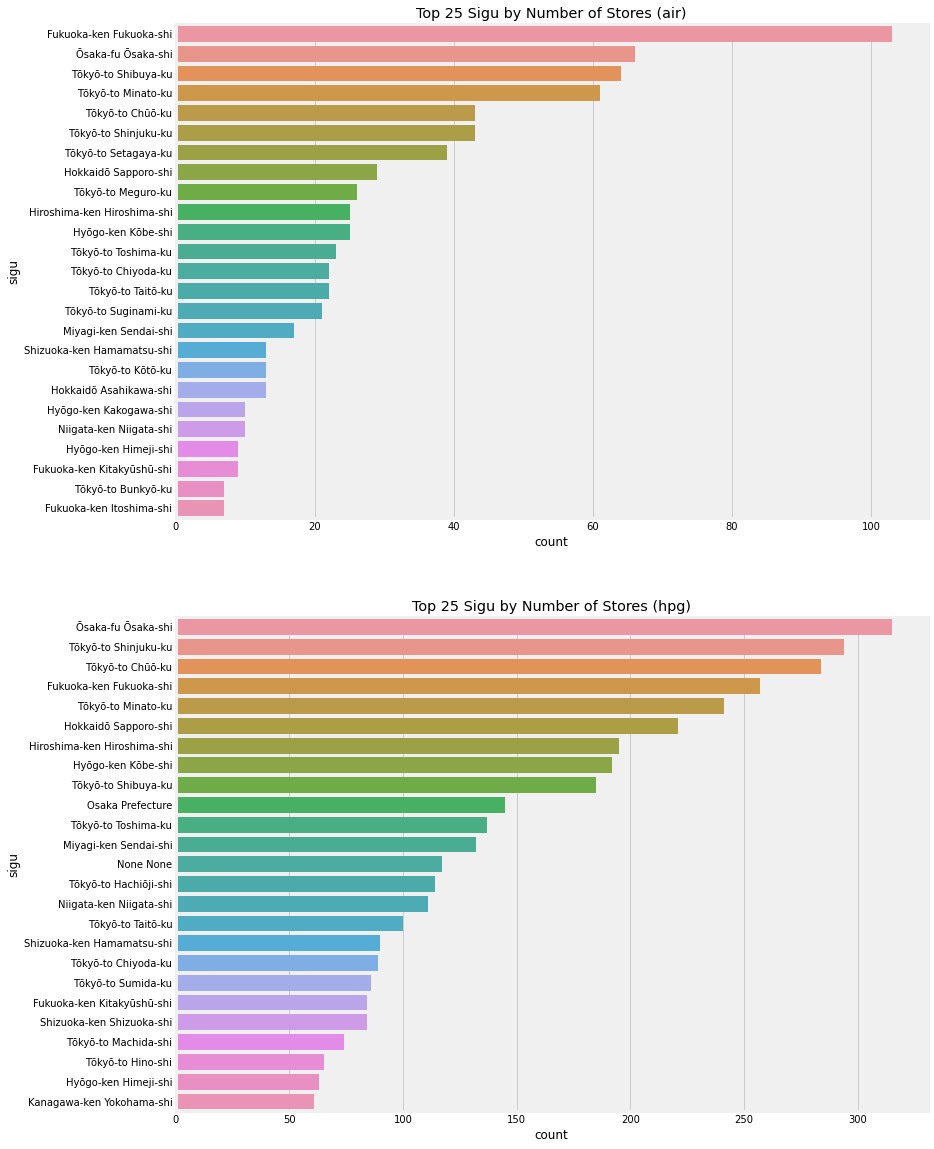

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,20))
sns.countplot(y=data['as']['sigu'],
             order=data['as']['sigu'].value_counts().iloc[:25].index, ax=ax1)
sns.countplot(y=data['hs']['sigu'],
             order=data['hs']['sigu'].value_counts().iloc[:25].index, ax=ax2)
ax1.set(title='Top 25 Sigu by Number of Stores (air)')
ax2.set(title='Top 25 Sigu by Number of Stores (hpg)')
plt.show()

### 15) 장르별 요일별 방문자수

In [ ]:
# datetime 정보 필요
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])    # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek              # 요일 컬럼 생성  (정수 0~6)
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()        # 요일명 컬럼 생성 (Monday ~ Sunday)
data['tra']['year'] = data['tra']['visit_date'].dt.year                  # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month                # month 컬럼 생성

data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)    # 연도-월 형태로 저장

In [ ]:
visit = pd.merge(data['tra'],data['as'])
visit.nunique()

air_store_id      829
visit_date        478
visitors          204
dow                 7
dow_name            7
year                2
month              12
year_mth           16
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

- 장르별, 요일별 방문객 수를 확인해보자.
- 전반적으로 방문자가 많은 장르는 이자카야, 카페, 다이닝 바, 이탈리안/프렌치 정도였다.
- 장르별 점포수 역시 이자카야, 카페, 다이닝바, 이탈리아 순으로 높았기 때문에 점포수에 따른 결과로 볼 수 있다.
- 가라오케, 파티 장르는 금, 토요일에 방문자가 급증했다.

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

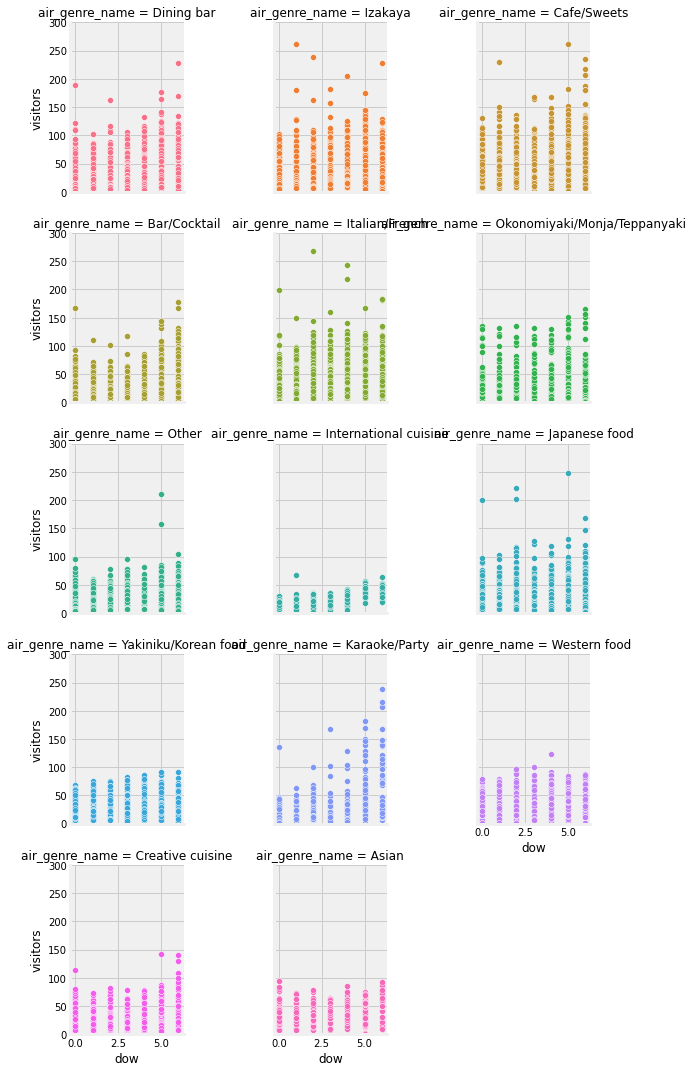

In [ ]:
plt.figure(figsize=(15,10))
sns.FacetGrid(visit, col='air_genre_name',hue='air_genre_name',col_wrap=3,
             ylim=(0,300)).map(sns.scatterplot,'dow','visitors')
plt.show()

### 16) 가게 유형별 방문자수
- 한 가게의 일일 방문자수가 877명에 육박하는 등 이상치가 존재한다.
- 가게 유형별 방문자 수의 분포를 보자.

<Figure size 1080x720 with 0 Axes>

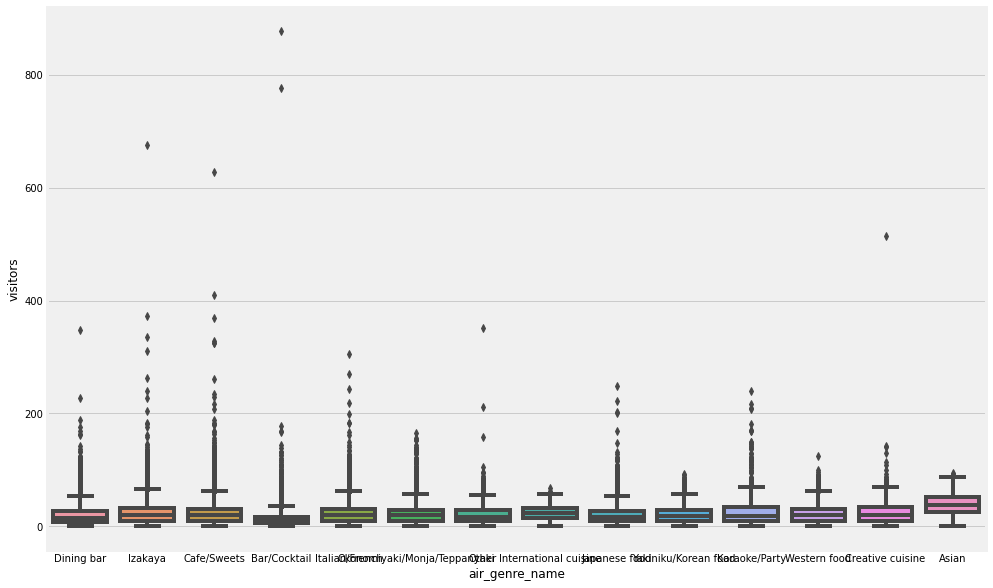

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data=visit, x='air_genre_name', y='visitors')
plt.show()

### 17) 위치별 방문자수 

<Figure size 1080x720 with 0 Axes>

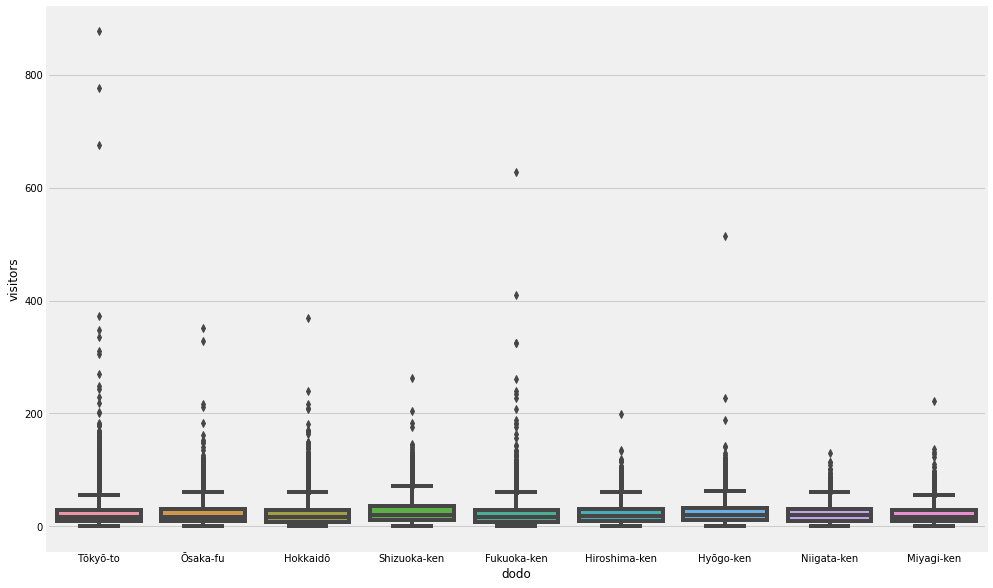

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data=visit, x='dodo', y='visitors')
plt.show()

## data6. store_id_relation
150개의 겹치는 가게 id 데이터이다.

## id 기준으로 store 정보 합치기

### air_store_info에 air_store_id와 일치하는 hpg_store_id 컬럼 대입

In [ ]:
data['as'] = pd.merge(data['as'], data['id'], how='inner', on=['air_store_id'])

### 'hpg_store_id' 기준으로 air_store_info 와 hpg_store_info 합치기

In [ ]:
store_merge = pd.merge(data['as'], data['hs'], how='left', on=['hpg_store_id']) 

### 18) air_store와 hpg_store 결측치 확인

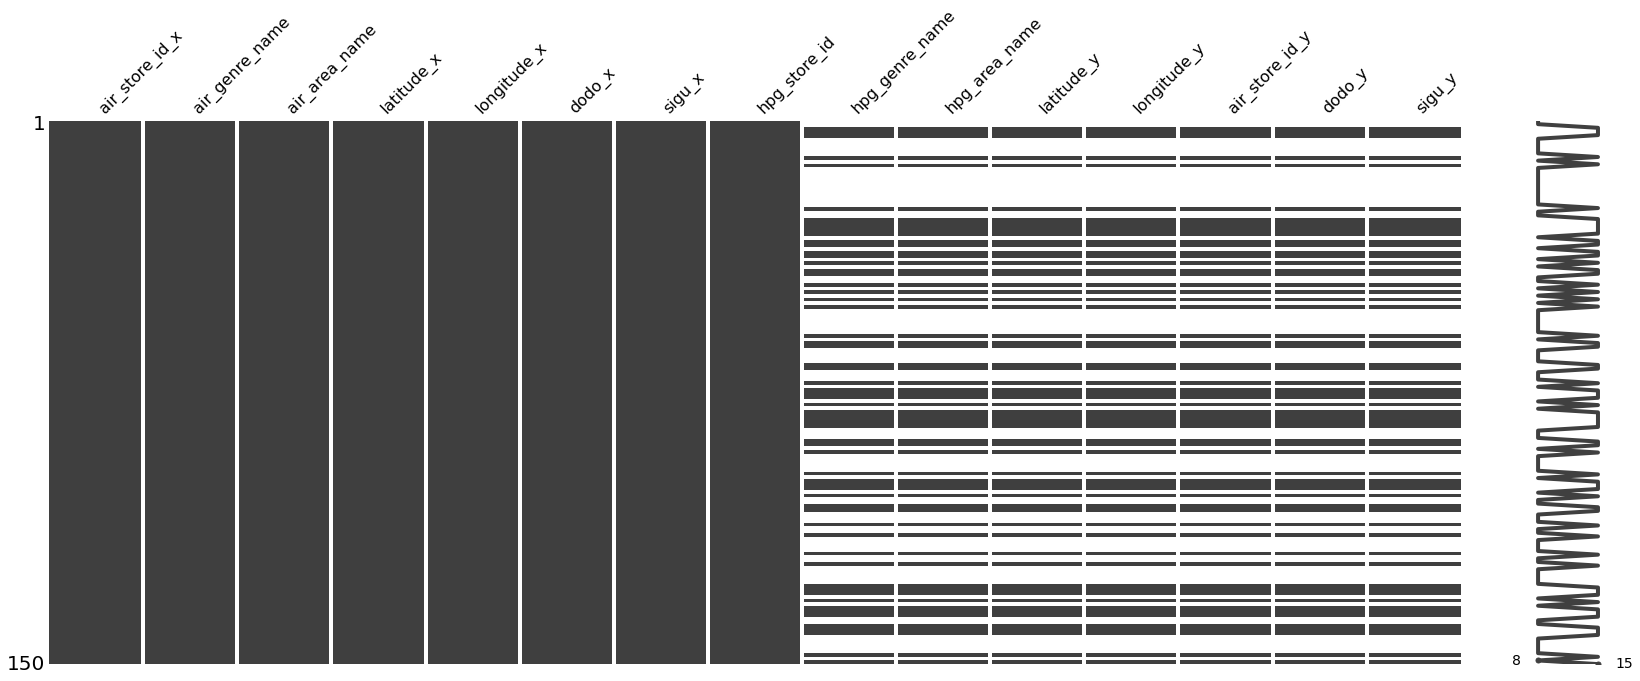

In [ ]:
import missingno as msno

msno.matrix(store_merge)

In [ ]:
store_merge.isnull().sum()

air_store_id_x     0
air_genre_name     0
air_area_name      0
latitude_x         0
longitude_x        0
dodo_x             0
sigu_x             0
hpg_store_id       0
hpg_genre_name    87
hpg_area_name     87
latitude_y        87
longitude_y       87
air_store_id_y    87
dodo_y            87
sigu_y            87
dtype: int64

### => hpg store 정보에 null값이 많이 보임

### 그 중 Null값인 row만 확인

In [ ]:
store_null =store_merge.loc[store_merge["hpg_genre_name"].isnull()]
store_null

,air_store_id_x,air_genre_name,air_area_name,latitude_x,longitude_x,dodo_x,sigu_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_store_id_y,dodo_y,sigu_y
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Tōkyō-to Minato-ku,hpg_c5ec63f52e4a7e9e,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,air_938ef91ecdde6878,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,Tōkyō-to Shibuya-ku,hpg_623477d346cf1822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,air_8e492076a1179383,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-ken Hiroshima-shi,hpg_aee92538e1b51d5f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,air_0867f7bebad6a649,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-ken Hiroshima-shi,hpg_caf1082b9f445c7b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,air_4c727b55acdee495,Creative cuisine,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353,Hyōgo-ken,Hyōgo-ken Himeji-shi,hpg_26d20b9f926ff5e9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,air_fea5dc9594450608,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,Shizuoka-ken,Shizuoka-ken Hamamatsu-shi,hpg_6507818140022452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,air_2cee51fa6fdf6c0d,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,Tōkyō-to Shibuya-ku,hpg_113fd6e4fa77800f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,air_b45b8e456f53942a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Hokkaidō,Hokkaidō Sapporo-shi,hpg_a85b37424291216b,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['hs'].loc[data['hs']['hpg_store_id']=='hpg_9b38b9e13da6da27']

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id,dodo,sigu


In [ ]:
data['as'].loc[data['as']['air_store_id']=='air_7cc17a324ae5c7dc']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,dodo,sigu,hpg_store_id
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,hpg_9b38b9e13da6da27


### => hpg store 정보가 없는  hpg store id 들이 존재했기 때문..
### => 같은 가게인데도 air_store_info에는 존재하고 hpg_store_info 에는 존재하지 않는 경우가 있다.

# data7. date_info

In [ ]:
# 휴일만
holiday = data['hol'].loc[data['hol']['holiday_flg'] ==1]

In [ ]:
holiday['day_of_week'].value_counts()  # 공휴일인 날의 요일 분포 확인 (공휴일은 월,화인 날이 많았다.)

1    9
4    7
2    5
0    5
3    4
6    3
5    2
Name: day_of_week, dtype: int64

In [ ]:
# 날짜 데이터 타입으로 변경
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])

In [ ]:
# 4월말에서 5월의 데이터를 2016년/2017년 따로 추출
holidays16 = data['hol'][((data['hol']['visit_date'] >'2016-04-15') & (data['hol']['visit_date'] < '2016-06-01'))]
holidays17 = data['hol'][((data['hol']['visit_date'] >'2017-04-15') & (data['hol']['visit_date'] < '2017-06-01'))]

### 19) 공휴일과 아닌 날의 count 비교

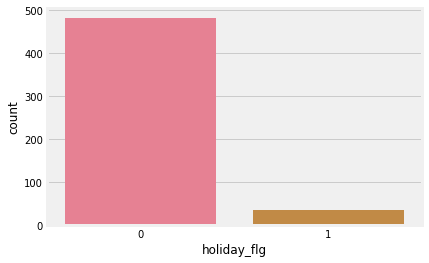

In [ ]:
sns.countplot(x="holiday_flg",data = data['hol']) 

[]

[[]]

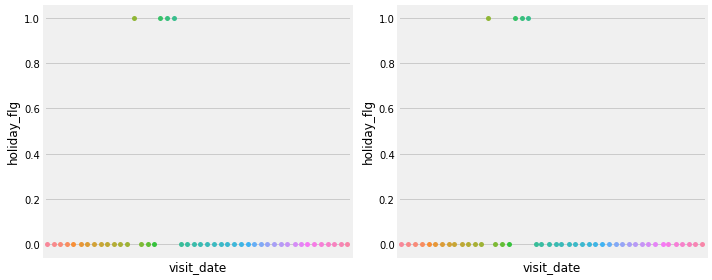

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
plt2 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays16, ax=ax1)
plt2.set_xticks([])

plt3 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays17, ax=ax2)
plt3.set(xticks=[])

plt.tight_layout()

- 2016년 4월 말과 5월은 2017년과 휴일이 같다. (4/29, 5/3,5/4,5/5)
- data에서 휴일의 비율은 대략 7%이다.

### 20) 공휴일여부에 따른 방문객평균

In [ ]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [ ]:
tra_hol_merge = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])


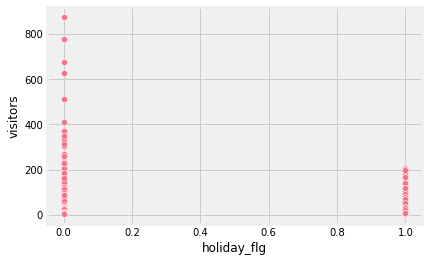

In [ ]:
sns.scatterplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 방문객이 400명을 넘는 경우는 공휴일이 아닌 날에 많이 존재함.

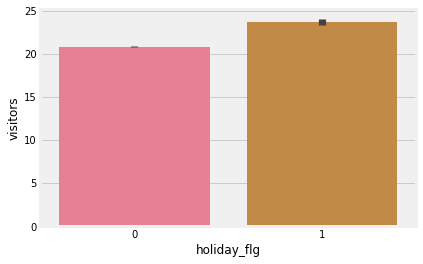

In [ ]:
sns.barplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 하지만 평균 방문자수는 공휴일일때 더 많다.

### 공휴일 요일에 따른 방문자평균

In [ ]:
tra_holiday_merge = pd.merge(data['tra'],data['hol'], how='left', on=['visit_date'])

### 20) 공휴일과 아닌 날의 요일 별 평균방문자수

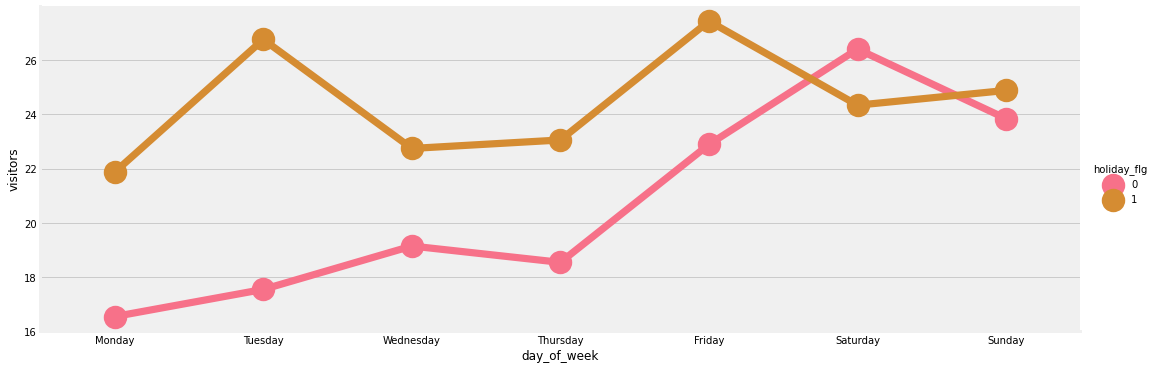

In [ ]:
df_visitors_by_dow = tra_holiday_merge.groupby(['day_of_week','holiday_flg']) \
                             .agg({'visitors':'mean'}) \
                             .reset_index() 
dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df_visitors_by_dow['day_of_week'] = pd.Categorical(df_visitors_by_dow['day_of_week'],categories=dow, ordered=True)
df_visitors_by_dow.sort_values(by='day_of_week', inplace=True)
sns.factorplot(x='day_of_week', y='visitors', data=df_visitors_by_dow, hue='holiday_flg', aspect=3)

* 화요일,금요일이 공휴일일때, 평균방문자수가 제일 많았다.
*  평균방문자 수가 공휴일이 아닌날은 토요일과 일요일에 제일 많다
* 공휴일일때 금요일이 많은 이유는 금토일 연달아 쉬니깐..? 
* 공휴일일때 토요일이 아닌날의 토요일보다 평균방문자수가 적은 이유는 공휴일이니깐 쉬고 싶어서..?

### 21) 공휴일여부에 따른 air 예약자 평균

In [ ]:
ar=ar.rename(columns={
            'visit_datetime': 'visit_date'
        })
ar['visit_date'] = pd.to_datetime(ar['visit_date'])

In [ ]:
ar['visit_date'] = pd.to_datetime(ar['visit_date'])
ar_hol_merge = pd.merge(ar, data['hol'], how='left', on=['visit_date'])
ar['visit_date'] = ar['visit_date'].dt.date

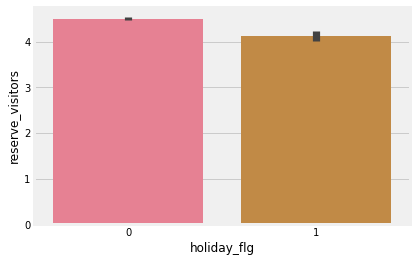

In [ ]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=ar_hol_merge)

* air 평균 예약자 수는 공휴일이 아닌 날에 더 많다.

### 22) 공휴일여부에 따른 hpg예약자 평균

In [ ]:
hr=hr.rename(columns={
            'visit_datetime': 'visit_date'
        })
hr['visit_date'] = pd.to_datetime(hr['visit_date'])

In [ ]:
hr_hol_merge = pd.merge(hr, data['hol'], how='left', on=['visit_date'])


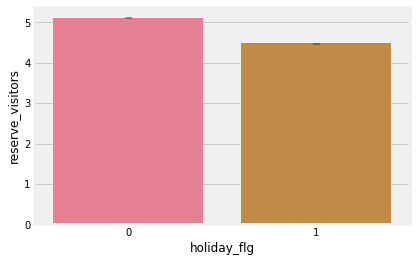

In [ ]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=hr_hol_merge)

* hpg 평균 예약자 수는 공휴일이 아닌 날에 더 많다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
import pandas as pd
import numpy as np
import time, datetime
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler ,RobustScaler

import warnings
warnings.filterwarnings("ignore")

# **파일 불러오기**

In [ ]:
path='/content/gdrive/MyDrive/AIFFEL/해커톤 1/recruit-restaurant-visitor-forecasting/'

In [ ]:
data = {
    'tra': pd.read_csv(path+'air_visit_data.csv.zip'),
    'as': pd.read_csv(path+'air_store_info.csv.zip'),
    'hs': pd.read_csv(path+'hpg_store_info.csv.zip'),
    'ar': pd.read_csv(path+'air_reserve.csv.zip'),
    'hr': pd.read_csv(path+'hpg_reserve.csv.zip'),
    'id': pd.read_csv(path+'store_id_relation.csv.zip'),
    'tes': pd.read_csv(path+'sample_submission.csv.zip'),
    'hol': pd.read_csv(path+'date_info.csv.zip').rename(columns={'calendar_date':'visit_date'})
    }

#  **데이터 확인하기**

##### **tra** : air restaurants의 과거 방문 data, main training data set (air_visit_data.csv)
* 총 데이터 수 : 252108개
* 방문기록이 있는 air_store_id : 829개


In [ ]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


##### **as** : air 레스토랑 세부 정보 (air_store_info.csv)
* air 레스토랑 세부 정보가 존재하는 식당 수   : 829개

In [ ]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


##### **hs** : hpg 레스토랑 세부 정보 (hpg_store_info.csv)
* * hpg 레스토랑 세부 정보가 존재하는 식당 수   : 4690개

In [ ]:
data['hs'].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


##### **ar** : air 레스토랑 예약 시스템 (air_reserve.csv)
* 총 데이터 수 : 92378개
* air 예약된 식당 수 : 314개

In [ ]:
data['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


##### **hr** : hpg 레스토랑 예약 시스템 (hpg_reserve.csv)
* 총 데이터 수 : 2000320개
* hpg 예약된 식당 수 : 13325개

In [ ]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


##### **id** : 동일한 가게에 대한 air & hpg id (store_id_relation.csv)
* 총 데이터 수 : 150개

In [ ]:
data['id'].head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


##### **hol** : 일본 공휴일 정보 (date_info.csv)
* 2016/01/01 ~ 2017/05/31 기간동안의 공휴일 정보
* 데이터를 합칠 때를 위해 calendar_date를 visit_date로 컬럼명을 변경하였음

In [ ]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


##### **tes** : test set으로 사용. (sample_submission.csv)
* ’id’는 air id와 방문 날짜를 결합하여 생성

In [ ]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


##### 데이터 정리

In [ ]:
print('[----Data structure----]')
print('Training data:\t\t',data['tra'].shape, '\tunique store id: ',len(data['tra']['air_store_id'].unique()))
print('Id data:\t\t',data['id'].shape)
print('Air store data:\t\t',data['as'].shape,'\tunique store id: ',data['as']['air_store_id'].unique().shape)
print('Hpg store data:\t\t',data['hs'].shape,'\tunique store id: ',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data:\t',data['ar'].shape,'\tunique store id: ',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data:\t',data['hr'].shape,'\tunique store id: ',data['hr']['hpg_store_id'].unique().shape)

[----Data structure----]
Training data:		 (252108, 3) 	unique store id:  829
Id data:		 (150, 2)
Air store data:		 (829, 5) 	unique store id:  (829,)
Hpg store data:		 (4690, 5) 	unique store id:  (4690,)
Air reserve data:	 (92378, 4) 	unique store id:  (314,)
Hpg reserve data:	 (2000320, 4) 	unique store id:  (13325,)


# **전처리하기**

##### 이상치 제거 (실제 방문객 수 중 450명을 넘으면 제거)


In [ ]:
data['tra']= data['tra'][data['tra']['visitors']<450]

In [ ]:
data['tra'].loc[data['tra']['visitors']>400] # 제거완료

,air_store_id,visit_date,visitors
167504,air_9828505fefc77d75,2016-11-19,409


##### air와 hpg에 둘 다 있는 가게는 150개밖에 없다 (= store_id_relation데이터의 크기) 
##### 따라서 air와 겹치는 hpg의 데이터만 가져와서 사용하기로 정하였다.

In [ ]:
# hpg 예약정보에 id 파일에서  hpg_store_id와 일치하는 air_store_id 정보를 추가함
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


##### air, hpg reservation 데이터
* air_store_id 기준으로 보기
* reserve_datetime_diff 컬럼 생성 : 예약을 진행한 날짜와 실제 방문할 날짜의 차이 => 며칠 전에 예약을 하는가?
* visit_datetime(날짜 + 시간) 형태에서 visit_date(날짜) 형태로 바꿈 
* 같은 날짜 다른 시간의 reserve_visitors 정보도 같은 날짜의 reserve_visitors로 합쳐짐.


In [ ]:
for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime']) # 데이터타입을 datatime으로 변경
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date # YYYY-MM-DD(문자) 형식으로 바꿈
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime']) 
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1) 
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'  
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'    # visit_datetime 에서 visit_date로 컬럼명 변경
        })
    print(data[df].head())

           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                      0                 2
1  air_00a91d42b08b08d9  2016-12-05                      4                 9
2  air_00a91d42b08b08d9  2016-12-14                      6                18
3  air_00a91d42b08b08d9  2016-12-17                      6                 2
4  air_00a91d42b08b08d9  2016-12-20                      2                 4
           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-01-14                      3                 2
1  air_00a91d42b08b08d9  2016-01-15                      6                 4
2  air_00a91d42b08b08d9  2016-01-16                      3                 2
3  air_00a91d42b08b08d9  2016-01-22                      3                 2
4  air_00a91d42b08b08d9  2016-01-29                      6                 5


##### tra : air 레스토랑 실제 방문날짜와 방문객수 전처리
* visit_date 컬럼에서 파생변수 만들기
* 날짜를 '년-월-일'의 형태로 변환한다.
* 요일 인덱스값, 연도, 월  feature를 추가한다.


In [ ]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [ ]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date']) # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek           # 요일 컬럼 생성(정수 0~6)
data['tra']['year'] = data['tra']['visit_date'].dt.year               # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month             # month 컬럼 생성
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date         # YYYY-MM-DD(문자) 형태로 변경
data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


##### tes : submission 데이터 전처리 
* id 컬럼 (air_store_id + visit_date) 로 분리하기
> 데이터 예시: <br>
'id'칼럼
  - air_00a91d42b08b08d9_2017-04-23	
  - air_00a91d42b08b08d9_2017-04-24
  - air_00a91d42b08b08d9_2017-04-25

따라서 split('\_')을 했을 때 인덱스2인 원소가 날짜에 해당한다.<br>
👉 'visit_date'칼럼 생성

<br>

split('\_')을 했을 때 인덱스0,1인 원소를 다시 '\_'로 붙이면 air id가 된다.<br>
👉 'air_store_id'칼럼 생성

* visit_date에서 파생변수 만들기

In [ ]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [ ]:
data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])                                   # visit_date 방문날짜 컬럼 만들기
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))                             # id 컬럼 만들기
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date']) # 날짜 데이터형식으로 변형
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek           # 요일 : 0~6
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


##### submission파일에서 air_store_id 유일한 값들만 찾기
=> test데이터셋에 등장하는 가게는 총 821개이다

In [ ]:
unique_stores = data['tes']['air_store_id'].unique() 
len(unique_stores)

821

##### 'stores' 데이터프레임 생성 
* submission에 있던 가게들('air_store_id')과 이 가게들이 각 요일마다 방문객 수가 어떤지를 보려고 만든 데이터프레임


In [ ]:
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores, # submission의 air_store_id 유일값들
            'dow': [i] * len(unique_stores)
        }) for i in range(7) # 요일 0~6
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

In [ ]:
stores.info() # 총 5747개의 데이터 = 821개의 가게 * 요일 7개 (0~6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5747 entries, 0 to 5746
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   air_store_id  5747 non-null   object
 1   dow           5747 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.9+ KB


In [ ]:
stores.head()

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0


##### store 데이터프레임에 'air_store_id', 'dow' 기준으로 실제 방문자 수에 대하여 최솟값, 평균값, 중앙값, 최댓값, count를 계산하고 새로운 feature로 추가한다.

In [ ]:
# 최소 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
# 평균 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
# 중앙값 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])


In [ ]:
# 최대 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
# 'air_store_id', 'dow' 기준으로 몇번 방문했나? 
# 예) a라는 레스토랑에 토요일에 방문한 데이터가 몇개인가?
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0


In [ ]:
#  58개의 null 값 존재 => 실제 방문 내역에 (특정 가게,특정요일) 조합이 58개가 없는 것 같다.
stores.isnull().sum()

air_store_id           0
dow                    0
min_visitors          58
mean_visitors         58
median_visitors       58
max_visitors          58
count_observations    58
dtype: int64

#####  store 데이터 프레임의 air_store_id와 일치하는 가게 정보(레스토랑 종류, 위치정보)만 가져와서 컬럼 추가 (hpg_store_info는 활용하지 않음)

In [ ]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


##### air_genre_name,	air_area_name 라벨인코딩하기

In [ ]:
lbl = preprocessing.LabelEncoder() # 라벨인코더 

In [ ]:
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name']) # 레스토랑 종류를 정수로 변환하여 저장한다.
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])   # 지역 이름을 정수로 변환하여 저장한다.
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,7,82,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,2,102,34.692337,135.472229


##### hol 전처리 : date_info 데이터에서 날짜, 요일을 이전과정과 같이 처리한다.
* 컬럼명 변경된 상태 'calendar_date'->'visit_date'
* 날짜 => 연,월,일만 저장
* 요일 라벨인코딩하기 (정수 0~6 으로 변환)

In [ ]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [ ]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])      # 날짜 데이터 타입으로 변경
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week']) # 요일 : 문자 -> 숫자(0~6)
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
data['hol'].head()


,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0


# **데이터 합치기** => train, test set 

In [ ]:
data['tra'].head(2)

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1


In [ ]:
data['hol'].head(2)

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1


In [ ]:
# 위의 두 데이터프레임을 visit_date 기준으로 합치기
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0


In [ ]:
# test set도 같은 방식으로 합침
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0


##### stores 데이터프레임을 train,test set에 추가하기

In [ ]:
#아이디와 요일기준으로 합치기
train = pd.merge(train, stores, how='left', on=['air_store_id', 'dow']) 
train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599


In [ ]:
# test set도 동일한 방식으로 합침
test = pd.merge(test, stores, how='left', on=['air_store_id', 'dow'])
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,2.000000,2.0,2.0,1.0,6,44,35.694003,139.753595
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,24.350000,24.5,43.0,40.0,6,44,35.694003,139.753595
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0,15.0,28.125000,28.0,52.0,40.0,6,44,35.694003,139.753595
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0,15.0,29.868421,30.0,47.0,38.0,6,44,35.694003,139.753595


##### train,test set에 air_store_id와 visit_date기준으로 reservation_diff랑 예약손님 수 컬럼 넣기

In [ ]:
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

In [ ]:
train.head(3)

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN


In [ ]:
# train과 test데이터 모두 결측치는 -1로 채운다.
train = train.fillna(-1)
test = test.fillna(-1)

In [ ]:
train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0


##### Binding to float32

In [ ]:
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

##### weather 데이터 추가

In [ ]:
# datetime 데이터 타입으로 변경
train.visit_date = pd.to_datetime(train.visit_date)
test.visit_date = pd.to_datetime(test.visit_date)

In [ ]:
def add_weather(dataset):                                                                                                                     
    print('Adding weather...')                                                                                                                
    air_nearest = pd.read_csv(                                                                                                                
        '/content/gdrive/MyDrive/AIFFEL/해커톤 1/recruit-restaurant-visitor-forecasting/air_store_info_with_nearest_active_station.csv')                                                              
    unique_air_store_ids = list(dataset.air_store_id.unique())                                                                                
                                                                                                                                              
    weather_dir = '/content/gdrive/MyDrive/AIFFEL/해커톤 1/recruit-restaurant-visitor-forecasting/1-1-16_5-31-17_Weather/'                                                                         
    weather_keep_columns = ['precipitation', 'avg_temperature'] # 강수량, 평균 온도 데이터                                                                                                                                
                                                                                                                                              
    dataset_with_weather = dataset.copy()                                                                                                     
    for column in weather_keep_columns:                                                                                                       
        dataset_with_weather[column] = np.nan                                                                                                 
                                                                                                                                              
    for air_id in unique_air_store_ids:                                                                                                       
        station = air_nearest[air_nearest.air_store_id == air_id].station_id.iloc[0]                                                          
        weather_data = pd.read_csv(weather_dir + station + '.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})                                                                                                                                           
                                                                                                                                              
        this_store = dataset.air_store_id == air_id                                                                                           
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')                                                         
                                                                                                                                              
        for column in weather_keep_columns:                                                                                                   
            dataset_with_weather.loc[this_store, column] = merged[column]                                                                     
    return dataset_with_weather                                                                                                               
# 컬럼 추가                                                                                                                                             
train = add_weather(train)                                                                                                                    
test = add_weather(test)  

Adding weather...
Adding weather...


In [ ]:
# train set 확인
train.head(3)

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y,precipitation,avg_temperature
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0,NaN,4.3
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292307,21.0,54.0,65.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0,NaN,6.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738461,35.0,61.0,65.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0,0.0,5.6


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252103 entries, 0 to 252102
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   air_store_id             252103 non-null  object        
 1   visit_date               252103 non-null  datetime64[ns]
 2   visitors                 252103 non-null  int64         
 3   dow                      252103 non-null  int64         
 4   year                     252103 non-null  int64         
 5   month                    252103 non-null  int64         
 6   day_of_week              252103 non-null  int64         
 7   holiday_flg              252103 non-null  int64         
 8   min_visitors             252103 non-null  float32       
 9   mean_visitors            252103 non-null  float32       
 10  median_visitors          252103 non-null  float32       
 11  max_visitors             252103 non-null  float32       
 12  count_observatio

##### train_x,train_y, test_x 

In [ ]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values) # target값 로그변환시켜 정규화
print(train_x.shape, train_y.shape)
test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)

(252103, 20) (252103,)


# **모델 생성 및 학습** /  **예측 및 제출 파일 생성**

In [ ]:
# parameter tuning of xgboost
# start from default setting
xgbm0 = xgb.XGBRegressor(
    max_depth=8,
    learning_rate=0.01,
    n_estimators=1000,random_state=0)

xgbm0.fit(train_x, train_y, eval_metric='rmse')

predict_y = gbm0.predict(test_x)
test['visitors'] = np.expm1(predict_y)
test[['id', 'visitors']].to_csv(
    'xgb0_submission_addweather_blending.csv', index=False, float_format='%.3f')

# 회고

## 데이터 전처리

1) air_visit_data에서 visitors의 최댓값이 877명이었다. <br>
휴일도 아니었고 골든위크도 아닌데 왜 이렇게 많았던 것일까? 심지어 평소엔 많이 와도 20명정도인 가게였다. => 이상치라고 생각!
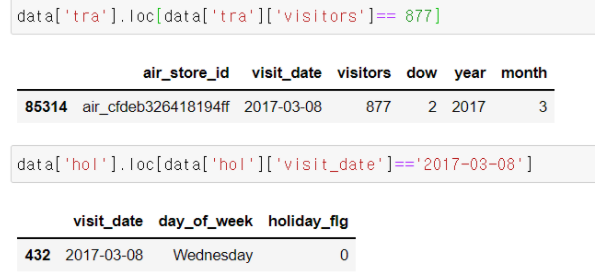 <br>
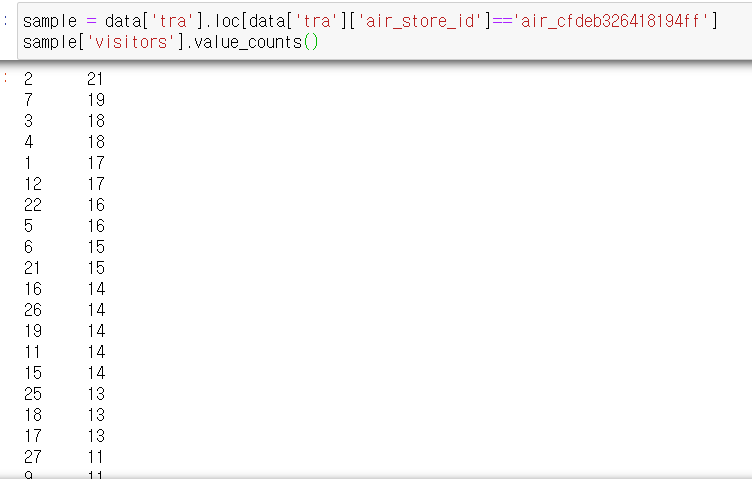


2) 노쇼 데이터<br>
노쇼를 한건지에 대해 알 수 있을까 궁금하여 air예약정보 데이터와 실제 방문 데이터를 합쳤다. <br>
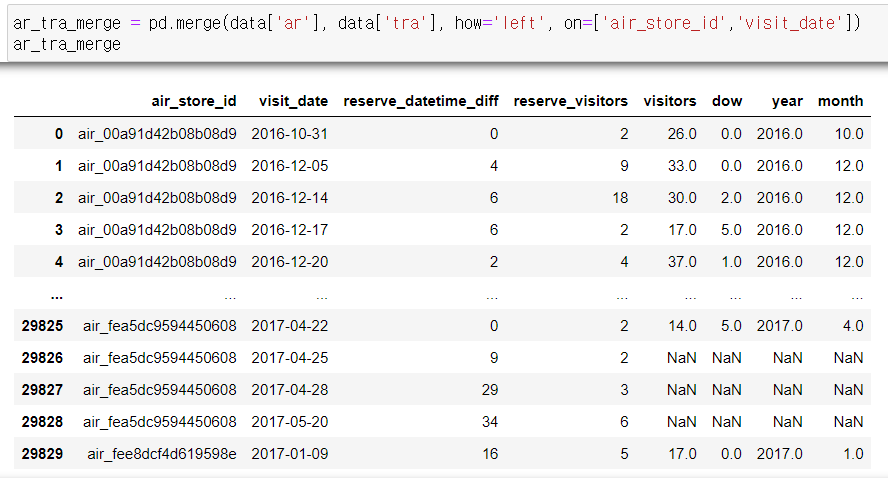 <br>
air 예약 정보의 air_store_id 기준으로 합쳤더니 실제 방문자 수 관련 컬럼에 NaN 값(visitors 컬럼에서 1766개의 null값)이 존재했다. <br>
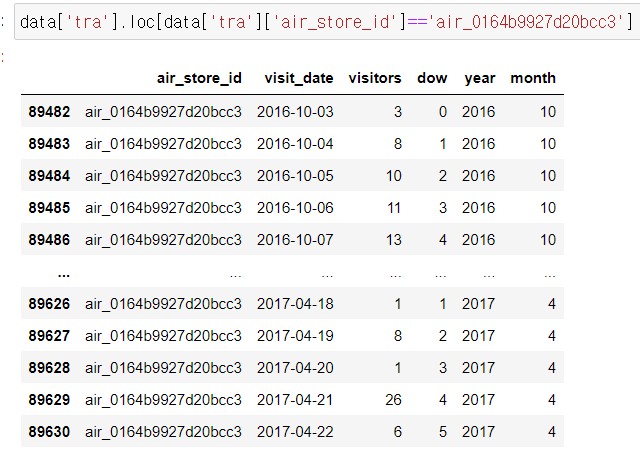 <br>
null 값을 가진 데이터의 air_store_id와 관련된 데이터를 air_visit_data에서 찾아보면 2017년 4월 23일부터 visit 데이터가 존재하지 않는다. 폐업한걸까? 아니면 그냥 방문자 기록을 안 한걸까? 노쇼를 했는데 기록이 안 된것일까? <br>
=> 한 가게의 예약한 날짜의 손님수와 그날 실제 방문한 손님수 비교를 하면 노쇼데이터를 알 수 있을거 같았지만 예약을 안 하고 방문한 손님이 더 많을시엔 비교가 불가능하다고 생각했다.


3) 날씨데이터 <br>
날씨데이터를 가져오는 코드가 적힌 커널을 참고하였다. 거의다 Nan 값이여서 결측치를 어떻게 채워야되나 고민하였다. 평균넣기, 결측치 바로 이전의 값으로 채우기(method='pad) 등의 방법을 써봤지만 그냥 NaN 그대로 학습 시켰을 때가 점수가 가장 좋았다. 결측치를 어떻게 처리해야될까?

4) 성능 높인 순서
1. 기존 코드(LightGBM) + 날씨데이터 : 0.49480
2. 기존 코드 + 날씨데이터 + 이상치제거 : 0.49460
3. 기존 코드 + 날씨데이터 + 이상치제거 + xgboost : 0.49448

## 모델 선정 및 튜닝
1) LightGBM
- 첫 베이스 라인으로 LightGBM을 사용했다.

2) 하이퍼 파라미터 튜닝
- 피쳐 엔지니어링으로 추가한 변수들에 따른 스코어 변화가 크지 않아서 하이퍼 파라미터 튜닝을 시도했다.
- 각자 나누어 GridSearch와 RandomizedSearch를 진행했다.
- 최대한 많은 경우의 수를 보기 위해서 파라미터 범위를 넓게 잡았더니 학습에 긴 시간이 소요되었다.
- 또한 오히려 이전에 비해 스코어가 나빠지기도 했다.

3) XGBoost 시도
- 이전 시도에서 추가했던 피쳐들과 함께 사용하는 모델을 변경해보았다.
- LightGBM에 비해서 학습 시간은 오래 소요되었지만 성능이 괜찮게 나오는 것을 볼 수 있었다.

## 참고한 커널

- [Restaurant Visitor Forecasting EDA with R (한글 번역)](https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r/report)
    - 다양한 방법으로 데이터 시각화를 전개하여 인사이트를 쉽게 얻을 수 있었다.
    - R로 작성된 코드를 파이썬으로 바꿔보면서 머릿속에 그렸던 플롯을 구현하는 연습을 할 수 있었다.



 - [Simple lightgbm LB:0.493](https://www.kaggle.com/festa78/simple-lightgbm-lb-0-493)
    - 가장 기본적인 데이터 전처리 과정을 볼 수 있었다. 추가적인 변수를 뽑아내는 것을 보고 더 나아가 새로운 변수를 유도할 수 있었다.

